## Second Analysis

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Caricamento dei dati
# Scaricati manualmente, organizzati in 9 file .csv
path_dati = "/Users/tommaso/Desktop/tesi-inflation-gt/Official_2"
nomi_gruppi = {
    "Gruppo1(2)": "Termini_Diretti",
    "Gruppo2(2)": "Alimentari",
    "Gruppo3(2)": "Energia",
    "Gruppo4(2)": "Abitazione",
    "Gruppo5(2)": "Trasporti",
    "Gruppo6(2)": "Politiche_Economiche",
    "Gruppo7(2)": "Aspettative_Consumatori",
    "Gruppo8(2)": "Sanita",
    "Gruppo9(2)": "Ricreazione"
}

# Funzione per caricare i dati GT
def carica_dati_gt(path, nomi_file):
    dati_gruppi = {}
    
    for nome_file, nome_gruppo in nomi_gruppi.items():
        file_path = os.path.join(path, f"{nome_file}.csv")
        
        try:
            # Salto le prime due righe (header = riga 3 del file)
            df = pd.read_csv(file_path, skiprows=2)
            
            # Normalizzo nomi colonne
            df.columns = [col.strip().lower() for col in df.columns]
            
            # Controllo presenza colonna 'mese'
            if 'mese' not in df.columns:
                raise ValueError(f"Colonna 'mese' non trovata in {nome_file}")
            
            # Imposto indice e converti in datetime
            df.set_index('mese', inplace=True)
            df.index = pd.to_datetime(df.index, format="%Y-%m")
            
            dati_gruppi[nome_gruppo] = df
            print(f"Dati caricati con successo per {nome_gruppo}")
        
        except Exception as e:
            print(f"Errore nel caricamento di {nome_file}: {e}")
    
    return dati_gruppi

# Carico i dati
dati_gruppi = carica_dati_gt(path_dati, nomi_gruppi)



Dati caricati con successo per Termini_Diretti
Dati caricati con successo per Alimentari
Dati caricati con successo per Energia
Dati caricati con successo per Abitazione
Dati caricati con successo per Trasporti
Dati caricati con successo per Politiche_Economiche
Dati caricati con successo per Aspettative_Consumatori
Dati caricati con successo per Sanita
Dati caricati con successo per Ricreazione


In [4]:
# 2. Allineamento delle scale usando "inflazione" come termine comune
def allinea_scale(dati_gruppi, query_riferimento="inflazione: (Italia)"):
    # Calcolo la media del termine di riferimento in ogni gruppo
    medie_riferimento = {}
    for gruppo, dati in dati_gruppi.items():
        cols_lower = [col.lower() for col in dati.columns]
        if query_riferimento.lower() in cols_lower:
            idx = cols_lower.index(query_riferimento.lower())
            col_name = dati.columns[idx]  # Nome originale con maiuscole/minuscole
            medie_riferimento[gruppo] = dati[col_name].mean()
    
    # Identifico il gruppo di base
    gruppo_base = list(medie_riferimento.keys())[0]
    fattore_base = medie_riferimento[gruppo_base]
    
    # Allineo tutti i gruppi alla scala del gruppo base
    dati_allineati = {}
    for gruppo, dati in dati_gruppi.items():
        if gruppo in medie_riferimento:
            fattore_scala = fattore_base / medie_riferimento[gruppo]
            dati_allineati[gruppo] = dati.copy()
            
            # Scalo tutte le colonne tranne eventuali colonne non numeriche
            for col in dati.columns:
                if pd.api.types.is_numeric_dtype(dati[col]):
                    dati_allineati[gruppo][col] = dati[col] * fattore_scala
    
    return dati_allineati

# Allineo i dati
dati_allineati = allinea_scale(dati_gruppi)

# 3. Gestione dei periodi temporali diversi
# In caso i file abbiano periodi diversi, bisogna trovare il periodo comune

def trova_periodo_comune(dati_gruppi):
    date_inizio = []
    date_fine = []
    
    for gruppo, df in dati_gruppi.items():
        date_inizio.append(df.index.min())
        date_fine.append(df.index.max())
    
    # Il periodo comune va dalla data di inizio più recente alla data di fine più antica
    inizio_comune = max(date_inizio)
    fine_comune = min(date_fine)
    
    print(f"Periodo comune identificato: {inizio_comune} a {fine_comune}")
    
    # Verifico che il periodo comune sia valido
    if inizio_comune >= fine_comune:
        print("Attenzione: rilevato nessun periodo comune tra i gruppi")
        return None, None
    
    return inizio_comune, fine_comune

inizio_comune, fine_comune = trova_periodo_comune(dati_allineati)

# 4. Filtro i dati per il periodo comune e combino in un unico dataset
def combina_dati(dati_allineati, inizio, fine, query_riferimento="inflazione: (Italia)"):
    if inizio is None or fine is None:
        print("Impossibile combinare i dati: periodo comune non valido")
        return None
    
    # Inizializzo il dataframe combinato
    df_combinato = pd.DataFrame(index=pd.date_range(start=inizio, end=fine, freq='MS'))
    print(f"DataFrame combinato inizializzato con {len(df_combinato)} righe")
    
    for gruppo, df in dati_allineati.items():
        # Filtro per il periodo comune
        df_periodo = df[(df.index >= inizio) & (df.index <= fine)]
        print(f"Gruppo '{gruppo}' filtrato: {df_periodo.shape[0]} righe")
        
        # Rinomino le colonne per identificare il gruppo
        for col in df_periodo.columns:
            # Evito duplicati della query di riferimento

            # Controllo se la colonna è il termine di riferimento
            if col.lower() != query_riferimento.lower() or gruppo == list(dati_allineati.keys())[0]:
                nome_colonna = f"{gruppo}_{col}"
                # Mi assicuro che l'indice corrisponda (controllo che la colonna esista già)
                if df_periodo.index.equals(df_combinato.index):
                    df_combinato[nome_colonna] = df_periodo[col]
                else:
                    # Se non corrisponde, uso il reindexing per allineare
                    df_temp = df_periodo.reindex(df_combinato.index, method='nearest')
                    df_combinato[nome_colonna] = df_temp[col]
                print(f"Colonna aggiunta: {nome_colonna}")
    
    print(f"Totale colonne nel DataFrame combinato: {df_combinato.shape[1]}")
    return df_combinato

# Combino i dati
df_gt_combinato = combina_dati(dati_allineati, inizio_comune, fine_comune)

# 4bis. Pulizia dei valori '< 1' da Google Trends
def sostituisci_valori_meno_di_1(df):
    df_clean = df.copy()
    
    print("== Log sostituzioni '< 1' per colonna ==")
    for col in df_clean.columns:
        count = df_clean[col].astype(str).str.count("< 1").sum()
        if count > 0:
            print(f"Colonna '{col}': {int(count)} valori '< 1' sostituiti con 0.5")
        
        # Sostituisco '< 1' con 0.5
        df_clean[col] = df_clean[col].replace("< 1", 0.5)
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')  # converti in float

        if df_clean[col].isnull().any():
            print(f"Attenzione: la colonna '{col}' contiene NaN dopo la sostituzione")

    return df_clean

# Debug verifica integrità dei dati
def check_per_valori_testuali(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            print(f"Attenzione: la colonna '{col}' contiene ancora stringhe!")
        elif df[col].isnull().any():
            print(f"Attenzione: la colonna '{col}' contiene NaN dopo la conversione!")

# Applico la pulizia
df_gt_combinato_clean = sostituisci_valori_meno_di_1(df_gt_combinato)

# Verifico integrità dei dati
check_per_valori_testuali(df_gt_combinato_clean)

# 5. Standardizzazione delle serie
def standardizza_serie(df):
    df_std = df.copy()
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            media = df[col].mean()
            std = df[col].std()
            if std != 0:
                df_std[col] = (df[col] - media) / std
                print(f"Standardizzata colonna: {col}")
            else:
                print(f"Attenzione! Colonna con deviazione standard nulla: {col} – lasciata invariata")
    return df_std

df_gt_std = standardizza_serie(df_gt_combinato_clean)



Periodo comune identificato: 2004-01-01 00:00:00 a 2024-12-01 00:00:00
DataFrame combinato inizializzato con 252 righe
Gruppo 'Termini_Diretti' filtrato: 252 righe
Colonna aggiunta: Termini_Diretti_inflazione: (italia)
Colonna aggiunta: Termini_Diretti_carrello della spesa: (italia)
Colonna aggiunta: Termini_Diretti_determinazione dei prezzi: (italia)
Colonna aggiunta: Termini_Diretti_costo della vita: (italia)
Colonna aggiunta: Termini_Diretti_risparmio: (italia)
Gruppo 'Alimentari' filtrato: 252 righe
Colonna aggiunta: Alimentari_prezzo pane: (italia)
Colonna aggiunta: Alimentari_prezzo latte: (italia)
Colonna aggiunta: Alimentari_prezzo pasta: (italia)
Colonna aggiunta: Alimentari_prezzo olio: (italia)
Gruppo 'Energia' filtrato: 252 righe
Colonna aggiunta: Energia_prezzo benzina: (italia)
Colonna aggiunta: Energia_prezzo diesel: (italia)
Colonna aggiunta: Energia_bolletta luce: (italia)
Colonna aggiunta: Energia_bolletta gas: (italia)
Gruppo 'Abitazione' filtrato: 252 righe
Colonna 

In [5]:
# 6. Creazione degli indici PCA per gruppo
# Organizzo le colonne per gruppo (già fatto dal prefisso nel nome colonna)

def crea_indici_pca_per_gruppo(df_std, nomi_gruppi):
    indici_pca = pd.DataFrame(index=df_std.index)
    
    for nome_gruppo in nomi_gruppi.values():
        # Filtro colonne di questo gruppo
        colonne_gruppo = [col for col in df_std.columns if col.startswith(f"{nome_gruppo}_")]
        
        if len(colonne_gruppo) > 1:  # PCA richiede almeno 2 variabili
            # Applico PCA
            pca = PCA(n_components=1)
            componente = pca.fit_transform(df_std[colonne_gruppo])
            
            # Salvo il primo componente principale come indice del gruppo
            indici_pca[f'indice_{nome_gruppo}'] = componente.flatten()
            
            # Stampo la varianza spiegata
            print(f"Gruppo {nome_gruppo}: {pca.explained_variance_ratio_[0]:.2%} della varianza spiegata")
            
            # Stampo i loadings (pesi) per interpretazione
            print("Loadings:")
            for i, col in enumerate(colonne_gruppo):
                print(f"  {col}: {pca.components_[0][i]:.4f}")
        
        elif len(colonne_gruppo) == 1:
            # Se c'è una sola colonna, la uso direttamente
            indici_pca[f'indice_{nome_gruppo}'] = df_std[colonne_gruppo[0]]
            print(f"Gruppo {nome_gruppo}: una sola colonna disponibile, usata direttamente")
    
    return indici_pca

# Creo indici per ogni gruppo
indici_pca_gruppi = crea_indici_pca_per_gruppo(df_gt_std, nomi_gruppi)



Gruppo Termini_Diretti: 40.61% della varianza spiegata
Loadings:
  Termini_Diretti_inflazione: (italia): 0.6230
  Termini_Diretti_carrello della spesa: (italia): 0.3465
  Termini_Diretti_determinazione dei prezzi: (italia): 0.5936
  Termini_Diretti_costo della vita: (italia): 0.3647
  Termini_Diretti_risparmio: (italia): -0.0803
Gruppo Alimentari: 88.65% della varianza spiegata
Loadings:
  Alimentari_prezzo pane: (italia): 0.4919
  Alimentari_prezzo latte: (italia): 0.4906
  Alimentari_prezzo pasta: (italia): 0.5166
  Alimentari_prezzo olio: (italia): 0.5005
Gruppo Energia: 78.28% della varianza spiegata
Loadings:
  Energia_prezzo benzina: (italia): 0.4138
  Energia_prezzo diesel: (italia): 0.5318
  Energia_bolletta luce: (italia): 0.5293
  Energia_bolletta gas: (italia): 0.5155
Gruppo Abitazione: 64.80% della varianza spiegata
Loadings:
  Abitazione_affitto casa: (italia): 0.5305
  Abitazione_bolletta acqua: (italia): 0.5663
  Abitazione_assicurazione casa: (italia): 0.4231
  Abitazio

Indice globale: 71.67% della varianza spiegata
Nessun NaN rilevato nel DataFrame finale.


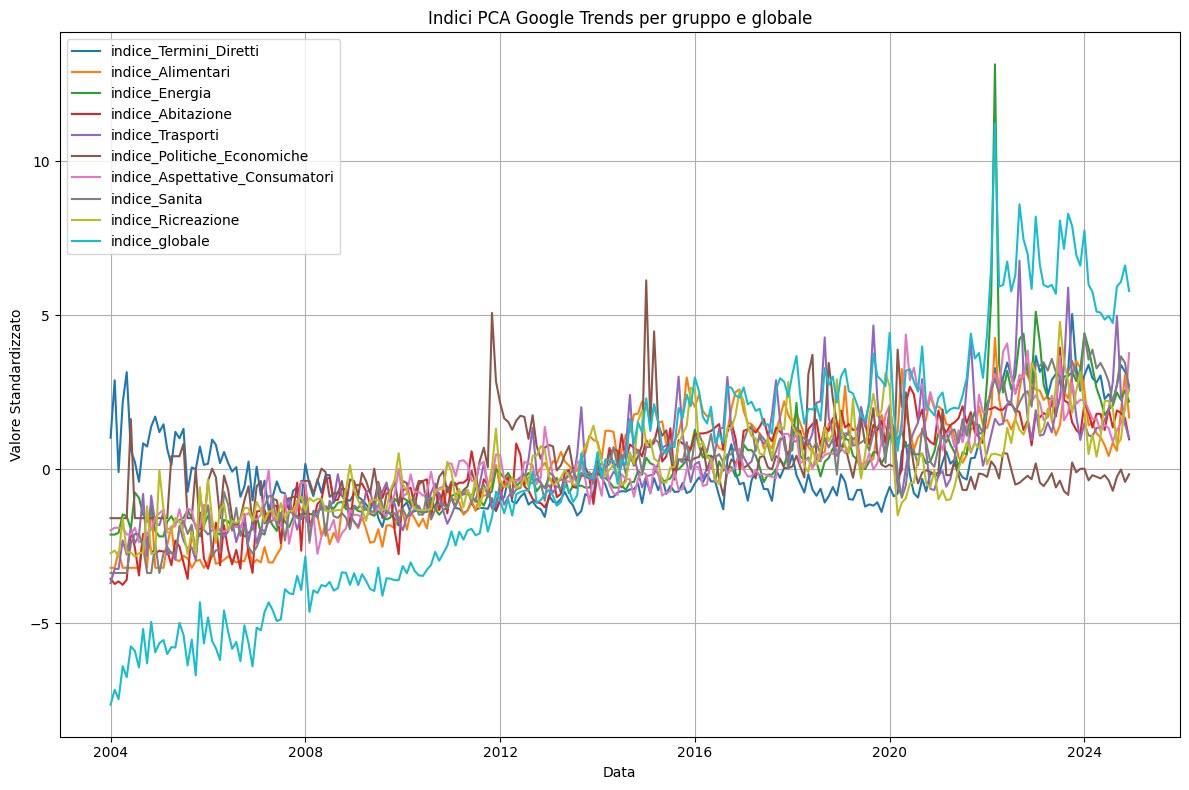

Indici salvati con successo in 'indici_google_trends.csv'


In [6]:
# 7. Creazione dell'indice globale
pca_globale = PCA(n_components=1)
indice_globale = pca_globale.fit_transform(indici_pca_gruppi)

# Aggiungo indice al dataframe
indici_pca_gruppi['indice_globale'] = indice_globale

# Log informativo di riassunto
print(f"Indice globale: {pca_globale.explained_variance_ratio_[0]:.2%} della varianza spiegata")

# Verifico NaN
if indici_pca_gruppi.isnull().values.any():
    print("Attenzione: il DataFrame finale contiene NaN")
else:
    print("Nessun NaN rilevato nel DataFrame finale.")

# Visualizzo gli indici
plt.figure(figsize=(12, 8))
for col in indici_pca_gruppi.columns:
    plt.plot(indici_pca_gruppi.index, indici_pca_gruppi[col], label=col)
plt.legend()
plt.title('Indici PCA Google Trends per gruppo e globale')
plt.xlabel('Data')
plt.ylabel('Valore Standardizzato')
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Salvo gli indici nella directory git
indici_pca_gruppi.to_csv('/Users/tommaso/Desktop/tesi-inflation-gt/PCA/indici_google_trends.csv', index=True)
print("Indici salvati con successo in 'indici_google_trends.csv'")



/var/folders/3m/15k2tqw90_s76rn9_8yw2p3r0000gn/T/ipykernel_94875/701472383.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=varianza, y=gruppi, palette="viridis")


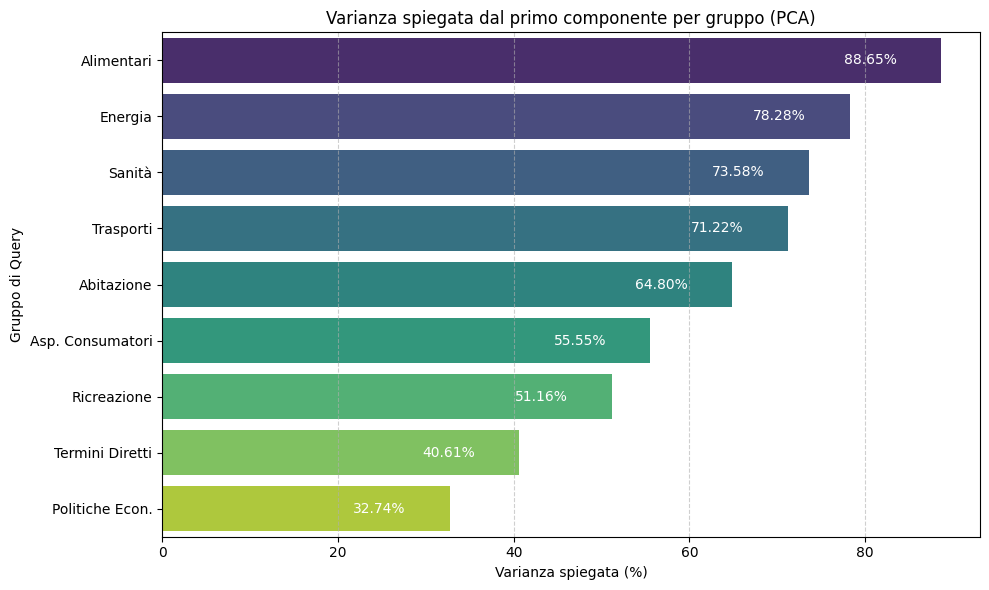

In [8]:
# 9. Visualizzazione della varianza spiegata
import seaborn as sns

# Dati
gruppi = [
    "Alimentari", "Energia", "Sanità", "Trasporti", "Abitazione", "Asp. Consumatori",
    "Ricreazione", "Termini Diretti", "Politiche Econ."
]
varianza = [88.65, 78.28, 73.58, 71.22, 64.80, 55.55, 51.16, 40.61, 32.74]

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=varianza, y=gruppi, palette="viridis")
plt.xlabel("Varianza spiegata (%)")
plt.ylabel("Gruppo di Query")
plt.title("Varianza spiegata dal primo componente per gruppo (PCA)")
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Risultati all’interno delle barre
for i, (value, label) in enumerate(zip(varianza, gruppi)):
    ax.text(value - 5, i, f"{value:.2f}%", color="white", va='center', ha='right', fontsize=10)

plt.tight_layout()
plt.show()
